<div align="center">

# <span style="color: #3498db;">CA2 - Genetic and Games Algorithm</span>

**<span style="color:rgb(247, 169, 0);">[Mohammad Sadra Abbasi]</span> - <span style="color:rgb(143, 95, 195);">[810101469]</span>**

</div>

# <span style="color: #3498db;">Genetic Algorithm</span>

## Imports

In [2]:
import time
import functools
import heapq
import math
from bisect import bisect_left
from itertools import accumulate
from random import randrange, random, uniform, shuffle, choice
from dataclasses import dataclass

from typing import List, Tuple, Optional, Dict, Callable, Type, Any

import numpy as np
from PIL import Image

import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.display import display, clear_output


## Image Analysis



In [3]:
class ImageAnalysis:
    def __init__(self, image: Image, rows: int, columns: int):
        self._image = image
        self._rows = rows
        self._columns = columns

        self._num_pieces = self._rows * self._columns
        
        self._pieces = self._split_image_pil()
        
        self._numpy_pieces = self._split_image_numpy()
        
        self.lr_matrix = np.zeros((self._num_pieces, self._num_pieces)) 
        self.td_matrix = np.zeros((self._num_pieces, self._num_pieces))
        self._dissimilarity_matrix = self._calculate_dissimilarity_matrix()

        self._best_matches_cache: Dict[Tuple[int, str], List[Tuple[float, int]]] = {}
        self._calculate_best_matches_cache()
        

    def _calculate_best_matches_cache(self):
        orientations = ["T", "D", "L", "R"]
        
        for piece_id in range(self._num_pieces):
            for orientation in orientations:
                all_matches = []
                
                for other_id in range(self._num_pieces):
                    if other_id == piece_id:
                        continue

                    if orientation == "R":
                        score = self.lr_matrix[piece_id, other_id]
                    elif orientation == "L":
                        score = self.lr_matrix[other_id, piece_id]
                    elif orientation == "D":
                        score = self.td_matrix[piece_id, other_id]
                    elif orientation == "T":
                        score = self.td_matrix[other_id, piece_id]
                    else:
                        continue
                        
                    all_matches.append((score, other_id))
                
                all_matches.sort(key=lambda x: x[0])
                
                # Store it in the cache
                self._best_matches_cache[(piece_id, orientation)] = all_matches

    @property
    def pieces(self) -> dict:
        return self._pieces

    def get_dissimilarity(self, ids: tuple, orientation: str) -> float:
        return self._dissimilarity_matrix[ids][orientation]

    def _split_image_pil(self) -> dict:
        width, height = self._image.size
        piece_width = width // self._columns
        piece_height = height // self._rows

        pieces = {}
        for i in range(self._rows):
            for j in range(self._columns):
                left = j * piece_width
                top = i * piece_height
                right = left + piece_width
                bottom = top + piece_height
                piece = self._image.crop((left, top, right, bottom))
                pieces[i * self._columns + j] = piece
        return pieces

    def _split_image_numpy(self) -> dict:
        width, height = self._image.size
        piece_width = width // self._columns
        piece_height = height // self._rows

        pieces_np = {}
        for i in range(self._rows):
            for j in range(self._columns):
                left = j * piece_width
                top = i * piece_height
                right = left + piece_width
                bottom = top + piece_height
                piece = self._image.crop((left, top, right, bottom))
                
                pieces_np[i * self._columns + j] = np.asarray(piece, dtype=np.float64)
        return pieces_np

    def _calculate_dissimilarity_matrix(self) -> dict:
        matrix = {}
        num_pieces = self._rows * self._columns
        for i in range(num_pieces):
            for j in range(num_pieces):
                if i == j:
                    continue
                    
                arr1 = self._numpy_pieces[i]
                arr2 = self._numpy_pieces[j]

                self.lr_matrix[i, j] = self._dissimilarity_measure(arr1, arr2, "L-R")
                self.td_matrix[i, j] = self._dissimilarity_measure(arr1, arr2, "T-D")
                
                matrix[i, j] = {
                    "L-R": self._dissimilarity_measure(arr1, arr2, "L-R"),
                    "T-D": self._dissimilarity_measure(arr1, arr2, "T-D"),
                }
        return matrix

    def _dissimilarity_measure(self, arr1: np.ndarray, arr2: np.ndarray, orientation: str) -> float:
        
        if orientation == "L-R":
            edge1 = arr1[:, -1]
            edge2 = arr2[:, 0]

        elif orientation == "T-D":
            edge1 = arr1[-1, :]
            edge2 = arr2[0, :]
        else:
            return 0.0

        dissimilarity = np.sum((edge1 - edge2) ** 2)
        
        return float(dissimilarity)
    
    @staticmethod
    def complementary_orientation(orientation):
        return {"T": "D", "R": "L", "D": "T", "L": "R"}.get(orientation)
    
    def get_best_matches(self, piece_id: int, orientation: str) -> List[Tuple[float, int]]:
        return self._best_matches_cache.get((piece_id, orientation), [])

## Size Detector

In [4]:

class SizeDetector:

    def __init__(self, image: Image, requested_piece_size: int):
        self._original_image = image
        self._req_size = requested_piece_size

        self._width, self._height = image.size
        base_min = min(self._width, self._height) // 60
        self._min_piece_size = max(16, base_min)

        self._max_piece_size = min(self._width, self._height)

        self._image = self._smart_resize_to_fit(self._original_image, requested_piece_size)

        self._width, self._height = self._image.size

    def _nearest_divisible(self, n: int, s: int) -> int:
        """Return the closest integer to n that is divisible by s."""
        down = n - (n % s)
        up = down + s
        return up if abs(up - n) < abs(n - down) else down


    def _smart_resize_to_fit(self, image: Image, piece_size: int) -> Image:
        """Resize as minimally as possible so width and height become divisible by piece_size."""

        w, h = image.size

        # Already divisible no need to change anything
        if (w % piece_size == 0) and (h % piece_size == 0):
            return image

        new_w = self._nearest_divisible(w, piece_size)
        new_h = self._nearest_divisible(h, piece_size)

        print(f"[INFO] Smart-resizing image from {w}x{h} → {new_w}x{new_h} for piece size {piece_size}px")

        return image.resize((new_w, new_h), Image.LANCZOS)


    def calculate_dims(self) -> Tuple[int, int, int]:
        """
        Return:
            rows, cols, piece_size_used
        """

        piece_size = self._req_size

        if piece_size < self._min_piece_size:
            print(f"[WARN] Requested size {piece_size}px too small → using {self._min_piece_size}px instead")
            piece_size = self._min_piece_size

        rows = self._height // piece_size
        cols = self._width // piece_size

        return rows, cols, piece_size


    @property
    def resized_image(self):
        """Image that is resized to perfectly fit the desired piece size."""
        return self._image


## Individual

In [5]:
class Individual:
    analysis: Optional['ImageAnalysis'] = None
    
    def __init__(self, pieces: dict, rows: int, columns: int, initial_state: List[int] = None):

        self._pieces = pieces
        self._rows = rows
        self._columns = columns

        if initial_state:
            self._chromosome_list = initial_state
        else:
            self._chromosome_list = list(self._pieces.keys())
            shuffle(self._chromosome_list)

        # Reshape the list into a 2D array
        self._chromosome = np.array(self._chromosome_list).reshape((self._rows, self._columns))

        # Initialize the fitness cache for faster access
        self._fitness_cache: Optional[float] = None

        self._id_to_pos: Dict[int, Tuple[int, int]] = {}
        for r in range(self._rows):
            for c in range(self._columns):
                piece_id = self._chromosome[r, c]
                self._id_to_pos[int(piece_id)] = (r, c)

    
    def get_neighbor_id_at(self, piece_id: int, orientation: str) -> int:
    
        current_pos = self._id_to_pos.get(piece_id)
        
        if current_pos is None:
            return None
            
        current_row, current_col = current_pos
        
        target_row, target_col = current_row, current_col
        
        if orientation == "T":
            target_row -= 1
        elif orientation == "R":
            target_col += 1
        elif orientation == "D":
            target_row += 1
        elif orientation == "L":
            target_col -= 1
        else:
            return None 

        if 0 <= target_row < self._rows and 0 <= target_col < self._columns:
            return self._chromosome[target_row, target_col]
        else:
            return None

    def calculate_left_right_dissimilarity(self) -> float:
        left_pieces = self._chromosome[:, :-1]
        right_pieces = self._chromosome[:, 1:]

        dissimilarities = self.analysis.lr_matrix[left_pieces, right_pieces]
        return np.sum(dissimilarities)

    def calculate_top_bottom_dissimilarity(self) -> float:
        top_pieces = self._chromosome[:-1, :]
        bottom_pieces = self._chromosome[1:, :]

        dissimilarities = self.analysis.td_matrix[top_pieces, bottom_pieces]
        return np.sum(dissimilarities)
    
    @property
    def fitness(self) -> float:
        if self._fitness_cache is not None:
            return self._fitness_cache
        
        left_right_dissimilarity = self.calculate_left_right_dissimilarity()
        top_bottom_dissimilarity = self.calculate_top_bottom_dissimilarity()
        self._fitness_cache = 1.0 / (left_right_dissimilarity + top_bottom_dissimilarity)
        return self._fitness_cache
        


    def piece_size(self) -> tuple:
        return self._pieces[0].size

    def piece_by_id(self, piece_id: int) -> Image:
        return self._pieces[piece_id]

    def to_image(self) -> Image:
        """Reassembles the individual into a single image."""
        piece_width, piece_height = self.piece_size()
        canvas_width = self._columns * piece_width
        canvas_height = self._rows * piece_height
        canvas = Image.new('RGB', (canvas_width, canvas_height))

        for i in range(self._rows):
            for j in range(self._columns):
                piece_id = self._chromosome[i, j]
                piece = self.piece_by_id(piece_id)
                canvas.paste(piece, (j * piece_width, i * piece_height))
        return canvas

    def __getitem__(self, key):
        return self._chromosome[key]

    def __repr__(self):
        return f"Individual(fitness={self.fitness})"

## Selection

In [6]:
def roulette_selection(population: List[Individual], elite_size: int) -> List[Tuple[Individual, Individual]]:

    # separate elite from selection pool
    selection_pool = population[elite_size:]
    pool_size = len(selection_pool)

    # if all population is elite, return empty
    if pool_size == 0:
        return []

    # calculate fitness for each individual
    fitness_values = [ind.fitness for ind in selection_pool]
    total_fitness = sum(fitness_values)

    # if total fitness is 0 chose randomly
    if total_fitness == 0:
        parent_pairs = []
        num_pairs_needed = len(population) - elite_size
        for _ in range(num_pairs_needed):
            p1 = selection_pool[randrange(pool_size)]
            p2 = selection_pool[randrange(pool_size)]
            parent_pairs.append((p1, p2))
        return parent_pairs

    # calculate probability of each individual and make distribution
    probabilities = [f / total_fitness for f in fitness_values]
    cumulative_probs = list(accumulate(probabilities))

    def select_one_parent():
        # generate random number
        spin = uniform(0, 1) 
        # find its index to insert
        index = bisect_left(cumulative_probs, spin)
        
        if index == pool_size:
            index = pool_size - 1
        return selection_pool[index]

    parent_pairs = []
    num_pairs_needed = len(population) - elite_size
    
    for _ in range(num_pairs_needed):
        parent1 = select_one_parent()
        parent2 = select_one_parent()
        parent_pairs.append((parent1, parent2))
        
    return parent_pairs

def tournament_selection(population: List[Individual], elite_size: int, tournament_size: int = 8) -> List[Tuple[Individual, Individual]]:    
    selection_pool = population[elite_size:]
    pool_size = len(selection_pool)
    
    if pool_size == 0:
        return []

    parent_pairs = []
    num_pairs_needed = len(population) - elite_size

    def _select_one_parent() -> Individual:
        tournament_contenders = [selection_pool[randrange(pool_size)] for _ in range(tournament_size)]
        winner = max(tournament_contenders, key=lambda ind: ind.fitness)
        return winner

    for _ in range(num_pairs_needed):
        parent1 = _select_one_parent()
        parent2 = _select_one_parent()
        parent_pairs.append((parent1, parent2))

    return parent_pairs

## Crossover

In [7]:
import heapq

SHARED_PIECE_PRIORITY = -10
BUDDY_PIECE_PRIORITY = -1

def complementary_orientation(orientation):
    return {"T": "D", "R": "L", "D": "T", "L": "R"}.get(orientation)

class Crossover:
    def __init__(self, parent1: Individual, parent2: Individual, analysis: ImageAnalysis  , use_shared_pieces: bool = True,  use_buddy_pieces: bool = True):
        self._parents = (parent1, parent2)
        self._analysis = analysis
        self._pieces_length = len(parent1._pieces)
        self._child_rows = parent1._rows
        self._child_columns = parent1._columns
        self._kernel = {}
        self._taken_positions = set()
        self._candidate_pieces = []
        self._min_row, self._max_row, self._min_column, self._max_column = 0, 0, 0, 0
        self._use_shared = use_shared_pieces
        self._use_buddy = use_buddy_pieces

    def run(self):
        self._initialize_kernel()

        while not self._is_kernel_full() and self._candidate_pieces:
            
            try:
                priority, (position, piece_id), relative_to = heapq.heappop(self._candidate_pieces)
            except IndexError:
                break
            
            if self._is_valid_piece(piece_id):
                self._put_piece_to_kernel(piece_id, position)
        
    def child(self) -> Individual:
        # some changes to the template
        # 1. Create a list of IDs (not Image objects)
        initial_state_list = [None] * self._pieces_length 
        
        # Get the full map of {id: Image} from the parent
        all_pieces_map = self._parents[0]._pieces 

        # 2. Fill the list with IDs from the kernel
        for piece_id, (row, column) in self._kernel.items():
            index = (row - self._min_row) * self._child_columns + (column - self._min_column)
            if 0 <= index < self._pieces_length:
                initial_state_list[index] = piece_id # Store the ID
        
        # 3. Find used/unused IDs (This is now correct)
        used_piece_ids = {pid for pid in initial_state_list if pid is not None}
        all_piece_ids = set(all_pieces_map.keys())
        unused_piece_ids = list(all_piece_ids - used_piece_ids)
        
        shuffle(unused_piece_ids)

        # 4. Fill empty spots in the ID list
        for i in range(self._pieces_length):
            if initial_state_list[i] is None:
                if unused_piece_ids:
                    initial_state_list[i] = unused_piece_ids.pop()
        
        # 5. Return the new Individual with the correct initial_state
        return Individual(
            all_pieces_map, 
            self._child_rows, 
            self._child_columns, 
            initial_state=initial_state_list
        )
    
    def _initialize_kernel(self):
        # This method is provided. It selects a random starting piece.
        root_piece_id = list(self._parents[0]._pieces.keys())[randrange(self._pieces_length)]
        self._put_piece_to_kernel(root_piece_id, (0, 0))

    def _put_piece_to_kernel(self, piece_id: int, position: tuple):
        # This method is provided. It adds a piece to the solution kernel.
        self._kernel[piece_id] = position
        self._taken_positions.add(position)
        self._update_candidate_pieces(piece_id, position)

    def _update_candidate_pieces(self, piece_id: int, position: tuple):
        # This method is provided. It finds available boundaries and adds new candidates.
        for orientation, pos in self._available_boundaries(position):
            self.add_piece_candidate(piece_id, orientation, pos)

    def add_piece_candidate(self, piece_id: int, orientation: str, position: tuple):
        
        relative_piece_info = (piece_id, orientation) 

        if self._use_shared:
            shared_id = self._get_shared_piece(piece_id, orientation)
            if self._is_valid_piece(shared_id):
                self._add_candidate_to_heap(SHARED_PIECE_PRIORITY, shared_id, position, relative_piece_info)
                return 

        if self._use_buddy:
            buddy_id = self._get_buddy_piece(piece_id, orientation)
            if self._is_valid_piece(buddy_id):
                self._add_candidate_to_heap(BUDDY_PIECE_PRIORITY, buddy_id, position, relative_piece_info)
                return 

        best_match_id, score = self._get_best_match_piece(piece_id, orientation)
        
        if self._is_valid_piece(best_match_id):
            self._add_candidate_to_heap(score, best_match_id, position, relative_piece_info)
    

    def _get_shared_piece(self, piece_id: int, orientation: str) -> int:
        try:
            neighbor1_id = self._parents[0].get_neighbor_id_at(piece_id, orientation)
            
            neighbor2_id = self._parents[1].get_neighbor_id_at(piece_id, orientation)

            if neighbor1_id is not None and neighbor1_id == neighbor2_id:
                
                if self._is_valid_piece(neighbor1_id):
                    return neighbor1_id
                    
        except AttributeError as e:
            print(f"Warning: Assumed method 'get_neighbor_id_at' not found in Individual class. {e}")
        return None

    def _get_buddy_piece(self, piece_id: int, orientation: str) -> int:
        piece_A_id = piece_id
        
        try:
            matches_for_A = self._analysis.get_best_matches(piece_A_id, orientation)
            
            if not matches_for_A:
                return None
                
            best_match_for_A_score, piece_B_id = matches_for_A[0]
            
            complement_orient = complementary_orientation(orientation)
            if complement_orient is None:
                return None 
            
            matches_for_B = self._analysis.get_best_matches(piece_B_id, complement_orient)
            
            if not matches_for_B:
                return None
                
            best_match_for_B_score, best_match_for_B_id = matches_for_B[0]
            
           
            if best_match_for_B_id == piece_A_id:
                if self._is_valid_piece(piece_B_id):
                    return piece_B_id
            
        except AttributeError as e:
            print(f"Warning: Assumed method 'get_best_matches' not found in ImageAnalysis class. {e}")
            
        return None

    def _get_best_match_piece(self, piece_id: int, orientation: str) -> tuple:
        try:
            best_matches = self._analysis.get_best_matches(piece_id, orientation)
            
            for score, match_id in best_matches:
                if self._is_valid_piece(match_id):
                    return match_id, score
                    
        except AttributeError as e:
            print(f"Warning: Assumed method 'get_best_matches' not found in ImageAnalysis class. {e}")

        return None, None

    def _add_candidate_to_heap(self, priority: int, piece_id: int, position: tuple, relative_piece: tuple):
        # This is a helper to push candidates to the heap.
        heapq.heappush(self._candidate_pieces, (priority, (position, piece_id), relative_piece))

    # The following helper methods for boundary checks are provided for you.
    def _available_boundaries(self, row_and_column):
        (row, column) = row_and_column
        boundaries = []
        if not self._is_kernel_full():
            positions = {"T": (row - 1, column), "R": (row, column + 1), "D": (row + 1, column), "L": (row, column - 1)}
            for orientation, position in positions.items():
                if position not in self._taken_positions and self._is_in_range(position):
                    self._update_kernel_boundaries(position)
                    boundaries.append((orientation, position))
        return boundaries

    def _is_kernel_full(self):
        return len(self._kernel) == self._pieces_length

    def _is_in_range(self, pos):
        return self._is_row_in_range(pos[0]) and self._is_column_in_range(pos[1])

    def _is_row_in_range(self, row):
        return abs(min(self._min_row, row)) + abs(max(self._max_row, row)) < self._child_rows

    def _is_column_in_range(self, col):
        return abs(min(self._min_column, col)) + abs(max(self._max_column, col)) < self._child_columns

    def _update_kernel_boundaries(self, pos):
        self._min_row, self._max_row = min(self._min_row, pos[0]), max(self._max_row, pos[0])
        self._min_column, self._max_column = min(self._min_column, pos[1]), max(self._max_column, pos[1])

    def _is_valid_piece(self, piece_id):
        return piece_id is not None and piece_id not in self._kernel


## Mutation

In [8]:
def mutation(individual: Individual, mutation_rate: float = 0.01) -> Individual:
    
    
    rows = individual._rows
    cols = individual._columns
    
    r1 = random.randrange(rows) 
    c1 = random.randrange(cols)
    
    r2 = random.randrange(rows)
    c2 = random.randrange(cols)
    
    if (r1, c1) == (r2, c2):
        pass

    mutated_list = individual._chromosome_list.copy()
    
    index1 = r1 * cols + c1
    index2 = r2 * cols + c2
    
    piece_id_1 = mutated_list[index1]
    mutated_list[index1] = mutated_list[index2]
    mutated_list[index2] = piece_id_1
    
    mutated_individual = Individual(
        pieces=individual._pieces, 
        rows=individual._rows, 
        columns=individual._columns, 
        initial_state=mutated_list
    )
    
    return mutated_individual

## Genetic Algorithm

In [9]:
import random
import time
from dataclasses import dataclass
from typing import List, Callable, Tuple, Optional

@dataclass
class GaResult:
    best_individual: object
    best_fitness_history: List[float]
    avg_fitness_history: List[float]
    total_time: float


@dataclass
class GeneticAlgorithm:
    image_path: str
    piece_size: int                
    population_size: int
    generations: int
    elite_size: int
    mutation_rate: float

    # Strategies (injected functions)
    crossover_factory: Callable
    selection_function: Callable
    mutation_function: Callable

    # Settings & UI flags
    verbose: bool = True
    show_live_plot: bool = False
    live_plot_delay: float = 0.05
    show_convergence_plot: bool = True

    # Cache for image analysis
    precomputed_analysis: Optional[object] = None 

    def _initialize_analysis(self):
        # Use cached analysis if available to save time
        if self.precomputed_analysis is not None:
            if self.verbose:
                print("Using pre-computed image analysis.")
            
            self.rows = self.precomputed_analysis._rows
            self.columns = self.precomputed_analysis._columns
            
            Individual.analysis = self.precomputed_analysis
            return self.precomputed_analysis

        try:
            # Load and analyze the target image
            image = Image.open(self.image_path)
            detector = SizeDetector(image, self.piece_size)
            resized_image = detector.resized_image
            rows, cols, final_piece_size = detector.calculate_dims()

            if self.verbose:
                print(f"Piece size: {final_piece_size}px")
                print(f"Grid dimensions: {rows} rows x {cols} columns")
                print(f"Resized image: {resized_image.size}")

            self.rows = rows
            self.columns = cols

            # Set static analysis for Individuals
            analysis = ImageAnalysis(resized_image, self.rows, self.columns)
            Individual.analysis = analysis
            return analysis

        except FileNotFoundError:
            print(f"Error: Image file not found at {self.image_path}")
            return None

    def _create_initial_population(self, analysis) -> List:
        if self.verbose:
            print(f"Creating initial population of {self.population_size} individuals...")
        
        return [
            Individual(analysis.pieces, self.rows, self.columns, initial_state=None) 
            for _ in range(self.population_size)
        ]

    def _run_generation(self, current_population, analysis):
        # 1. Sort population by fitness (descending)
        current_population.sort(key=lambda person: person.fitness, reverse=True)
        
        best_fitness = current_population[0].fitness
        average_fitness = sum(person.fitness for person in current_population) / self.population_size

        # 2. Elitism: Keep the best performing individuals
        next_generation = current_population[:self.elite_size]
        
        # Calculate how many new children we need
        needed_children = self.population_size - self.elite_size
        
        # 3. Select parents for reproduction
        parent_pairs = self.selection_function(current_population, self.elite_size)

        # 4. Crossover and Mutation loop
        children_count = 0
        
        for parent_1, parent_2 in parent_pairs:
            if children_count >= needed_children:
                break
                
            # Create a new child from parents
            crossover_process = self.crossover_factory(parent_1, parent_2, analysis)
            crossover_process.run()
            child = crossover_process.child()
            
            # Apply random mutation
            if random.random() < self.mutation_rate:
                child = self.mutation_function(child)
            
            next_generation.append(child)
            children_count += 1

        # Sanity check
        if len(next_generation) != self.population_size:
            raise RuntimeError(f"Population mismatch! Expected {self.population_size}, got {len(next_generation)}")

        return next_generation, best_fitness, average_fitness

    def _report_progress(self, generation_index, best_person, avg_fitness, progress_bar=None):
        best_val = best_person.fitness
        
        if self.show_live_plot:
            clear_output(wait=True)
            plt.figure(figsize=(6, 6))
            plt.imshow(best_person.to_image())
            message = (f"Generation: {generation_index + 1}/{self.generations}\n"
                       f"Best Fitness: {best_val:.6g}\n"
                       f"Avg Fitness: {avg_fitness:.6g}")
            plt.title(message)
            plt.axis('off')
            plt.show()
            if self.verbose:
                print(message)
            time.sleep(self.live_plot_delay)
        
        elif progress_bar:
            progress_bar.set_description(f"Gen {generation_index+1} | Best: {best_val:.4f} | Avg: {avg_fitness:.4f}")

    def _plot_convergence(self, result):
        if self.verbose:
            print("Plotting fitness history...")
        plt.figure(figsize=(10, 5))
        plt.plot(result.best_fitness_history, label="Best Fitness")
        plt.plot(result.avg_fitness_history, label="Average Fitness")
        plt.xlabel("Generation")
        plt.ylabel("Fitness Score")
        plt.title("Convergence Over Time")
        plt.legend()
        plt.grid(True)
        plt.show()

    def run(self) -> GaResult:
        start_time = time.time()
        
        # Initialize resources
        analysis = self._initialize_analysis()
        if not analysis:
            return None
        
        current_population = self._create_initial_population(analysis)

        if self.verbose:
            print(f"Starting genetic evolution for {self.generations} generations...")
        
        fitness_history_best = []
        fitness_history_avg = []

        # Setup progress bar
        generation_iterator = range(self.generations)
        progress_bar = None
        if self.verbose and not self.show_live_plot:
            progress_bar = tqdm(generation_iterator, desc="Evolving")
            generation_iterator = progress_bar

        if self.show_live_plot:
            clear_output(wait=True)

        # Main evolution loop
        for generation in generation_iterator:
            current_population, current_best, current_avg = self._run_generation(current_population, analysis)
            
            fitness_history_best.append(current_best)
            fitness_history_avg.append(current_avg)

            self._report_progress(generation, current_population[0], current_avg, progress_bar)

        elapsed_time = time.time() - start_time
        
        if self.verbose:
            print(f"\nEvolution finished in {elapsed_time:.2f} seconds.")
            print(f"Final Best Fitness: {fitness_history_best[-1]}")
        
        result = GaResult(
            best_individual=current_population[0],
            best_fitness_history=fitness_history_best,
            avg_fitness_history=fitness_history_avg,
            total_time=elapsed_time
        )

        if self.show_convergence_plot:
            self._plot_convergence(result)
            
        return result

## Running the Algorithm

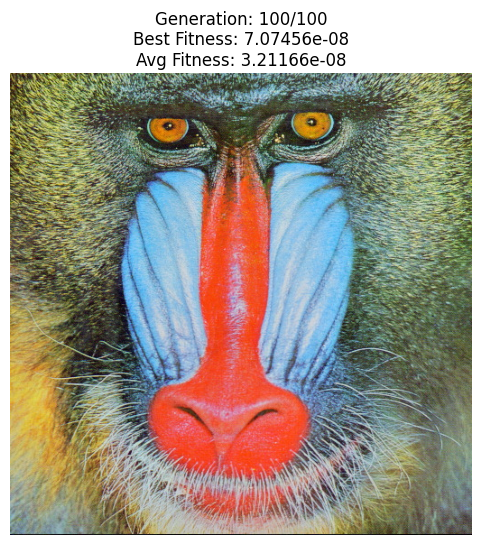

Generation: 100/100
Best Fitness: 7.07456e-08
Avg Fitness: 3.21166e-08

Evolution finished in 28.24 seconds.
Final Best Fitness: 7.074559346921959e-08
Plotting fitness history...


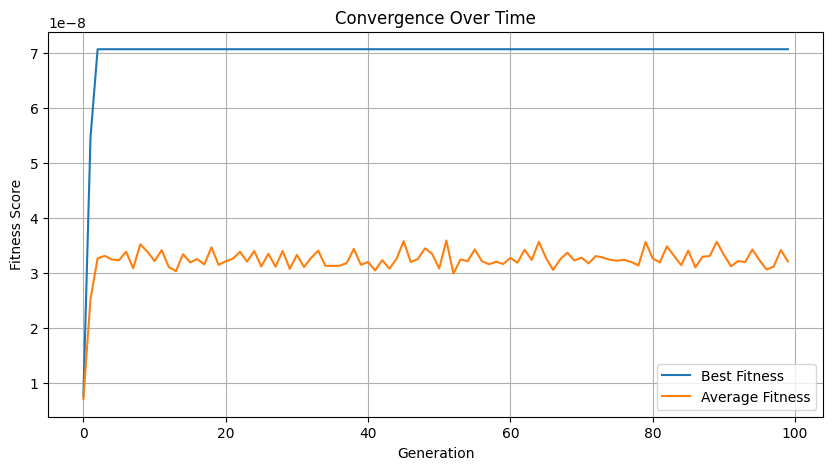

--- Final Best Solution ---


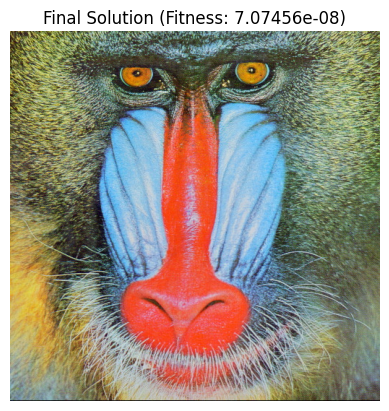

In [17]:
select_roulette_adapted = roulette_selection
select_tournament_adapted = tournament_selection


crossover_factory_default = lambda p1, p2, an: Crossover(
    p1, p2, an, 
    use_shared_pieces=True, 
    use_buddy_pieces=False
)

mutation_standard = mutation



IMAGE_PATH = './images/baboon.jpg'

# Other GA parameters
POP_SIZE = 100
GENERATIONS = 100
ELITE_SIZE = 5
MUTATION_RATE = 0.3
REASONABLE_DELAY = 0.0
PIECE_SIZE = 64

ga = GeneticAlgorithm(
    image_path=IMAGE_PATH,
    piece_size=PIECE_SIZE,
    population_size=POP_SIZE,
    generations=GENERATIONS,
    elite_size=ELITE_SIZE,
    mutation_rate=MUTATION_RATE,
    
    selection_function=select_roulette_adapted,
    # selection_function=select_tournament_adapted,
    crossover_factory=crossover_factory_default,
    mutation_function=mutation_standard,
    


    verbose=True,
    show_live_plot=True,
    live_plot_delay=REASONABLE_DELAY,
    show_convergence_plot=True
)

# Run the algorithm
result = ga.run()

# Show the final best solution
if result and result.best_individual:
    print("--- Final Best Solution ---")
    plt.imshow(result.best_individual.to_image())
    plt.title(f"Final Solution (Fitness: {result.best_individual.fitness:.6g})")
    plt.axis('off')
    plt.show()
else:
    print("GA run failed or was interrupted.")

## بررسی تاثیر روش انتخاب بر همگرایی


### Roulette wheel selection

In [ ]:
select_roulette_adapted = roulette_selection


crossover_factory_default = lambda p1, p2, an: Crossover(
    p1, p2, an, 
    use_shared_pieces=True, 
    use_buddy_pieces=True
)

mutation_standard = mutation



IMAGE_PATH = './images/baboon.jpg'

# Other GA parameters
POP_SIZE = 100
GENERATIONS = 100
ELITE_SIZE = 1
MUTATION_RATE = 0.05
REASONABLE_DELAY = 0.0
PIECE_SIZE = 32


ga = GeneticAlgorithm(
    image_path=IMAGE_PATH,
    piece_size=PIECE_SIZE,
    population_size=POP_SIZE,
    generations=GENERATIONS,
    elite_size=ELITE_SIZE,
    mutation_rate=MUTATION_RATE,
    
    selection_function=select_roulette_adapted,
    crossover_factory=crossover_factory_default,
    mutation_function=mutation_standard,

    verbose=True,
    show_live_plot=False,
    live_plot_delay=REASONABLE_DELAY,
    show_convergence_plot=True
)

# Run the algorithm
result = ga.run()

# Show the final best solution
if result and result.best_individual:
    print("--- Final Best Solution ---")
    plt.imshow(result.best_individual.to_image())
    plt.title(f"Final Solution (Fitness: {result.best_individual.fitness:.6g})")
    plt.axis('off')
    plt.show()
else:
    print("GA run failed or was interrupted.")

### Tournament Selection

In [ ]:
select_tournament_adapted = tournament_selection

crossover_factory_default = lambda p1, p2, an: Crossover(
    p1, p2, an, 
    use_shared_pieces=True, 
    use_buddy_pieces=True
)

mutation_standard = mutation

IMAGE_PATH = './images/baboon.jpg'

# Other GA parameters
POP_SIZE = 100
GENERATIONS = 100
ELITE_SIZE = 1
MUTATION_RATE = 0.05
REASONABLE_DELAY = 0.0
PIECE_SIZE = 32

ga = GeneticAlgorithm(
    image_path=IMAGE_PATH,
    piece_size=PIECE_SIZE,
    population_size=POP_SIZE,
    generations=GENERATIONS,
    elite_size=ELITE_SIZE,
    mutation_rate=MUTATION_RATE,
    
    selection_function=select_tournament_adapted,
    crossover_factory=crossover_factory_default,
    mutation_function=mutation_standard,

    verbose=True,
    show_live_plot=False,
    live_plot_delay=REASONABLE_DELAY,
    show_convergence_plot=True
)

# Run the algorithm
result = ga.run()

# Show the final best solution
if result and result.best_individual:
    print("--- Final Best Solution ---")
    plt.imshow(result.best_individual.to_image())
    plt.title(f"Final Solution (Fitness: {result.best_individual.fitness:.6g})")
    plt.axis('off')
    plt.show()
else:
    print("GA run failed or was interrupted.")

### تحلیل نمودار ها

| Roulette Wheel Selection  | Tournament Selection  |
| :---: | :---: |
| ![نمودار رولت](./covergence_result/roulette_selection.png) | ![نمودار تورنمنت](./covergence_result/tournament_selection.png) |

---

<div dir="rtl" style="text-align: justify; font-family: Tahoma, sans-serif; line-height: 1.6;">

<h3 style="margin-top: 15px;">نتیجه‌گیری:</h3>

<p>
برای تحلیل این دو نمودار، ابتدا باید مفهوم کلیدی «فشار انتخاب» (Selection Pressure) را تعریف کنیم. فشار انتخاب به تمایل الگوریتم برای انتخاب انحصاری افراد قوی‌تر (با Fitness بالا) اشاره دارد.
</p>

<p>
<b>Roulette Selection (فشار انتخاب زیاد):</b>
در این روش، شانس انتخاب شدن افراد کاملاً متناسب با Fitness آن‌هاست و افراد قوی احتمال بسیار بیشتری برای انتخاب شدن دارند. همین موضوع باعث می‌شود افراد ضعیف شانس کمی برای بقا داشته باشند و جمعیت بسیار سریع به سمت یک نقطه همگرا شود. بنابراین تنوع ژنتیکی (Diversity) کاهش می‌یابد.
</p>

<p>
<b>Tournament Selection (فشار انتخاب کم):</b>
در این روش، حتی افراد ضعیف‌تر هم شانس بقا دارند؛ زیرا انتخاب نهایی فقط بر اساس مقایسه در یک گروه کوچک (مثلاً ۸ فرد) انجام می‌شود. بنابراین حتی اگر یک فرد ضعیف در گروهی قرار گیرد که افراد خیلی قوی‌تری در آن نیستند، ممکن است انتخاب شود. این مکانیزم باعث حفظ تنوع ژنتیکی و کاهش سرعت همگرایی می‌شود.
</p>

<p>
<b>تحلیل نمودارها:</b>
با توجه به نمودارها می‌توان این نتایج را مشاهده کرد:  
در نمودار Roulette (فشار زیاد)، خط نارنجی (Average Fitness) در سطح پایین‌تری قرار می‌گیرد و نوسان بیشتری دارد، چون افراد ضعیف‌تر سریع حذف می‌شوند و رقابت شدید به همگرایی سریع منجر می‌شود.  
در مقابل، در نمودار Tournament (فشار کم)، خط نارنجی (Average Fitness) پایدارتر (Stable) و در سطح بالاتری قرار دارد. این نشان می‌دهد که به دلیل فشار انتخاب پایین‌تر، افراد ضعیف فرصت بیشتری برای بقا دارند و تنوع ژنتیکی حفظ می‌شود، که مانع همگرایی زودرس می‌گردد.
</p>

</div>


## مقایسه و آزمایش دو حالت متفاوت کراس اور 

### version that use shared, buddy and best pieces

In [ ]:
select_roulette_adapted = roulette_selection

crossover_factory_default = lambda p1, p2, an: Crossover(
    p1, p2, an, 
    use_shared_pieces=True, 
    use_buddy_pieces=True
)

mutation_standard = mutation

IMAGE_PATH = './images/baboon.jpg'

# Other GA parameters
POP_SIZE = 100
GENERATIONS = 200
ELITE_SIZE = 5
MUTATION_RATE = 0.02
REASONABLE_DELAY = 0.0
PIECE_SIZE = 32

ga = GeneticAlgorithm(
    image_path=IMAGE_PATH,
    piece_size=PIECE_SIZE,
    population_size=POP_SIZE,
    generations=GENERATIONS,
    elite_size=ELITE_SIZE,
    mutation_rate=MUTATION_RATE,
    
    selection_function=select_roulette_adapted,
    crossover_factory=crossover_factory_default,
    mutation_function=mutation_standard,
    


    verbose=True,
    show_live_plot=False,
    live_plot_delay=REASONABLE_DELAY,
    show_convergence_plot=True
)

# Run the algorithm
result = ga.run()

# Show the final best solution
if result and result.best_individual:
    print("--- Final Best Solution ---")
    plt.imshow(result.best_individual.to_image())
    plt.title(f"Final Solution (Fitness: {result.best_individual.fitness:.6g})")
    plt.axis('off')
    plt.show()
else:
    print("GA run failed or was interrupted.")

### version that use shared and best pieces

In [ ]:
select_roulette_adapted = roulette_selection

crossover_factory_default = lambda p1, p2, an: Crossover(
    p1, p2, an, 
    use_shared_pieces=True, 
    use_buddy_pieces=False
)

mutation_standard = mutation



IMAGE_PATH = './images/baboon.jpg'

# Other GA parameters
POP_SIZE = 100
GENERATIONS = 200
ELITE_SIZE = 5
MUTATION_RATE = 0.02
REASONABLE_DELAY = 0.0
PIECE_SIZE = 32


ga = GeneticAlgorithm(
    image_path=IMAGE_PATH,
    piece_size=PIECE_SIZE,
    population_size=POP_SIZE,
    generations=GENERATIONS,
    elite_size=ELITE_SIZE,
    mutation_rate=MUTATION_RATE,
    
    selection_function=select_roulette_adapted,
    crossover_factory=crossover_factory_default,
    mutation_function=mutation_standard,
    


    verbose=True,
    show_live_plot=False,
    live_plot_delay=REASONABLE_DELAY,
    show_convergence_plot=True
)

# Run the algorithm
result = ga.run()

# Show the final best solution
if result and result.best_individual:
    print("--- Final Best Solution ---")
    plt.imshow(result.best_individual.to_image())
    plt.title(f"Final Solution (Fitness: {result.best_individual.fitness:.6g})")
    plt.axis('off')
    plt.show()
else:
    print("GA run failed or was interrupted.")

### مقایسه و تحلیل استراتژی‌های Crossover

<div align="center">

| Use all three priorities (Buddy included) | Use "Shared" and "Best Match" only |
| :---: | :---: |
| <img src="./crossover_result/2flag_32*32.png" width="800"> | <img src="./crossover_result/1flag_32*32.png" width="800"> |
| **32×32 Piece Size (Small State Space)** | **32×32 Piece Size (Small State Space)** |
| <img src="./crossover_result/2flag_16*16.png" width="800"> | <img src="./crossover_result/1flag_16*16.png" width="800"> |
| **16×16 Piece Size (Large State Space)** | **16×16 Piece Size (Large State Space)** |

</div>


<div dir="rtl" style="text-align: justify; line-height: 1.8;">
    <h3 style="margin-top: 15px;">تحلیل اثر ابعاد فضای حالت:</h3>
    <p>
    <b>۱. فضای حالت کوچک‌تر (Piece Size: 32x32):</b><br>
    در این حالت، اضافه کردن اولویت <code>piece_buddy</code> نه‌تنها بهبود محسوسی ایجاد نمی‌کند، بلکه باعث افزایش زمان اجرا می‌شود. در تصاویری که بخش‌های هم‌رنگ و یکنواخت دارند ، معیار Buddy ممکن است دچار خطا  شود؛ یعنی دو قطعه‌ی آبی آسمانی که لزوماً همسایه نیستند، به اشتباه بهترین همسایه تشخیص داده شوند. در فضای کوچک، الگوریتم ساده‌تر می‌تواند بدون این سربار محاسباتی و با ریسک کمتر، به جواب برسد.
    </p>
    <p>
    <b>۲. فضای حالت بزرگ‌تر (Piece Size: 16x16):</b><br>
    با افزایش تعداد قطعات، فضای جستجو به صورت نمایی رشد می‌کند. در اینجا، یافتن اتصالات صحیح به صورت تصادفی بسیار دشوار است. اولویت <code>piece_buddy</code> در این حالت با قفل کردن قطعاتی که پیوند قوی دارند، از تخریب بلوک‌های درست‌چیده شده جلوگیری می‌کند و فضای جستجو را کاهش می‌دهد.
    </p>
</div>

<br>

<div align="center">

| Image with High Texture Complexity |
| :---: |
| <img src="./output_images/starry_g10_s64.png" width="1000"> |
| **(High Entropy / Unique Edges)** |

</div>

<div dir="rtl" style="text-align: justify; line-height: 1.8;">
    <h3 style="margin-top: 15px;">تحلیل اثر بافت و جزئیات تصویر:</h3>
    <p>
    علاوه بر ابعاد مسئله، <b>جنس تصویر (Image Texture)</b> نیز نقش تعیین‌کننده‌ای در کارایی استراتژی‌ها دارد:
    </p>
    <p>
    <b>تصاویر با بافت غنی و جزئیات بالا (مانند Starry):</b><br>
    برخلاف تصاویر ساده، در این تصاویر تغییرات پیکسل‌به‌پیکسل و تنوع رنگی بسیار زیاد است. این ویژگی باعث می‌شود لبه‌های هر قطعه تقریباً منحصر‌به‌فرد باشند. در نتیجه:
    </p>
    <ul>
        <li>احتمال اینکه دو قطعه به اشتباه Buddy یکدیگر شوند، بسیار پایین است (دقت بالا).</li>
        <li>رابطه‌ی Buddy در اینجا مانند یک «قفل مطمئن» عمل می‌کند که قطعات را دقیقاً در جای درست خود تثبیت می‌کند.</li>
    </ul>
    <p>
    به همین دلیل، مشاهده می‌شود که برای این نوع تصاویر، استفاده از اولویت Buddy نتیجه‌ای <b>بسیار بهتر و دقیق‌تر</b> نسبت به حالت ساده ارائه می‌دهد 
    </p>
</div>

## بررسی نتایج به ازای نسل های مختلف (10,15,20) و سایز های مختلف (32,64,128)


In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import os
import glob
import gc

# Selection + crossover configs
select_roulette_adapted = roulette_selection
crossover_factory_all = lambda p1, p2, an: Crossover(p1, p2, an, use_shared_pieces=True, use_buddy_pieces=True)
crossover_factory_no_buddy = lambda p1, p2, an: Crossover(p1, p2, an, use_shared_pieces=True, use_buddy_pieces=False)
mutation_standard = mutation

# Image dataset
IMAGE_DIR = './images/' 
IMAGE_FILES = glob.glob(os.path.join(IMAGE_DIR, '*.jpg'))

# Test configs
generation_list = [10, 15, 20]
piece_size_list = [32, 64, 128]

POP_SIZE = 100
ELITE_SIZE = 5
MUTATION_RATE = 0.02

# Output directory
OUTPUT_DIR = "./output_images"
os.makedirs(OUTPUT_DIR, exist_ok=True)


for image_path in IMAGE_FILES:
    base_image_name = os.path.basename(image_path).split('.')[0]

    print("\n\n=======================================================")
    print(f"=== Processing Image: {base_image_name.upper()} ===")
    print("=======================================================")

    # Try to load image safely
    try:
        with Image.open(image_path) as img:
            pass
    except FileNotFoundError:
        print(f"[ERROR] Image not found: {image_path}")
        continue

    # Loop piece sizes (Outer Loop - Optimized)
    for size in piece_size_list:
        
        # Calculate Analysis ONCE for this size
        print(f"\n>>> Preparing Analysis for Piece Size={size}px ...")
        with Image.open(image_path) as img:
            detector = SizeDetector(img, size)
            resized_img = detector.resized_image
            rows, cols, _ = detector.calculate_dims()
            
            # Heavy calculation happens here ONLY ONCE per size
            shared_analysis = ImageAnalysis(resized_img, rows, cols)
            print(">>> Analysis Ready.")

        # Loop generations (Inner Loop)
        for gen in generation_list:

            print(f"\n--- Testing: Gen={gen}, Piece Size={size}px ---")

            results_to_plot = []

            # ========== RUN 1: With Buddy Matching ==========
            ga_all = GeneticAlgorithm(
                image_path=image_path,
                piece_size=size,
                population_size=POP_SIZE,
                generations=gen,
                elite_size=ELITE_SIZE,
                mutation_rate=MUTATION_RATE,
                selection_function=select_roulette_adapted,
                crossover_factory=crossover_factory_all,
                mutation_function=mutation_standard,
                verbose=False,
                show_live_plot=False,
                show_convergence_plot=False,
                precomputed_analysis=shared_analysis
            )
            res_all = ga_all.run()
            results_to_plot.append(("With Buddy", res_all))

            del ga_all

            # ========== RUN 2: No Buddy Matching ==========
            ga_no_buddy = GeneticAlgorithm(
                image_path=image_path,
                piece_size=size,
                population_size=POP_SIZE,
                generations=gen,
                elite_size=ELITE_SIZE,
                mutation_rate=MUTATION_RATE,
                selection_function=select_roulette_adapted,
                crossover_factory=crossover_factory_no_buddy,
                mutation_function=mutation_standard,
                verbose=False,
                show_live_plot=False,
                show_convergence_plot=False,
                precomputed_analysis=shared_analysis
            )
            res_no_buddy = ga_no_buddy.run()
            results_to_plot.append(("No Buddy", res_no_buddy))

            del ga_no_buddy

            # ========== PLOT RESULTS ==========
            fig, axes = plt.subplots(1, 2, figsize=(8, 4))
            fig.suptitle(f"{base_image_name.capitalize()} - Gen={gen}, Size={size}px", fontsize=12)

            for i, (title, res) in enumerate(results_to_plot):
                ax = axes[i]
                if res and res.best_individual:
                    ax.imshow(res.best_individual.to_image())
                    fitness_val = res.best_individual.fitness
                    ax.set_title(f"{title}\nFit: {fitness_val:.2e}", fontsize=9)
                else:
                    ax.text(0.5, 0.5, "Run Failed", ha='center', va='center', fontsize=9)
                    ax.set_title(f"{title} (Failed)", fontsize=9)
                ax.axis('off')

            plt.tight_layout(rect=[0, 0, 1, 0.9])

            save_path = os.path.join(OUTPUT_DIR, f"{base_image_name}_g{gen}_s{size}.png")
            plt.savefig(save_path)
            print(f"  [Saved to {save_path}]")

            # ===== CLEAN MEMORY =====
            plt.close(fig)
            plt.clf()
            plt.close('all')

            del res_all, res_no_buddy, results_to_plot, fig, axes
            gc.collect()
        
        # Clean up analysis object before moving to next size
        del shared_analysis
        gc.collect()

## Genetic Results


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import glob

OUTPUT_DIR = "./output_images"
IMAGE_NAMES = ["starry", "baboon", "island", "chessboard", "lion", "pillars"]
GENERATIONS = [10, 15, 20]
PIECE_SIZES = [32, 64, 128]

def show_results_grid(base_name):
    fig, axes = plt.subplots(len(GENERATIONS), len(PIECE_SIZES), figsize=(15, 12))
    fig.suptitle(f"Results for Image: {base_name.upper()}", fontsize=20, y=1.02)

    for i, gen in enumerate(GENERATIONS):
        for j, size in enumerate(PIECE_SIZES):
            ax = axes[i, j]
            
            filename = f"{base_name}_g{gen}_s{size}.png"
            filepath = os.path.join(OUTPUT_DIR, filename)
            
            if os.path.exists(filepath):
                img = mpimg.imread(filepath)
                ax.imshow(img)
                
                title = f"Size: {size}px | Gen: {gen}"
                ax.set_title(title, fontsize=10, fontweight='bold')
            else:
                ax.text(0.5, 0.5, "Image Not Found", ha='center', va='center')
                ax.set_title(f"Missing: g{gen}_s{size}")
            
            ax.axis('off')

    plt.tight_layout()
    plt.show()

for name in IMAGE_NAMES:
    sample_file = glob.glob(os.path.join(OUTPUT_DIR, f"{name}_*.png"))
    if sample_file:
        show_results_grid(name)
    else:
        print(f"No results found for {name}")

## سوالات
---

<div dir="rtl" style="text-align: justify; line-height: 1.8;">
    <h3 style="margin-top: 15px;">سوال ۱:</h3>

<p>
    برای یک پازلِ <b>۶ × ۸</b> تعداد قطعات برابر با <b>۴۸</b> است. هر کروموزوم یک جایگشت
    (Permutation) از این ۴۸ قطعه را نشان می‌دهد. بنابراین فضای تمام حالت‌های ممکن برابر است با !48
</p>
<p>
     تقریب به نزدیک‌ترین توان ۱۰ با لگاریتم بر مبنای ۱۰ :
</p>
<p style="direction:ltr; text-align:left;">
    log₁₀(48!) = Σ log₁₀(k)  &nbsp;&nbsp;&nbsp; for k = 1 to 48  ==>  log₁₀(48!) ≈ 61.12
</p>
<p>
    بنابراین مقدار !48 تقریبا برابر است با:
</p>
<p style="direction:ltr; text-align:left;">
    48! ≈ 10^61.12  ≈ 10^61
</p>
<p>
    <b>نتیجه:</b> فضای جستجوی کل تقریبا برابر 10^61 است
</p>
</div>

---


<div dir="rtl" style="text-align: justify; line-height: 1.9; font-family: Tahoma;">
<h3 style="margin-top: 20px;">سوال ۲:</h3>

<p>
در ادامه سه خروجی از اجرای الگوریتم ژنتیک روی تصویر صفحه‌ی شطرنج آورده شده است (برای سه اندازه‌ی مختلف قطعه):
</p>

<table style="width: 100%; text-align: center; margin: 25px 0;">
    <tr>
        <td><img src="./output_images/chessboard_g20_s32.png" width="800"></td>
        <td><img src="./output_images/chessboard_g20_s64.png" width="800"></td>
        <td><img src="./output_images/chessboard_g20_s128.png" width="800"></td>
    </tr>
    <tr>
        <td>قطعه 32 پیکسل</td>
        <td>قطعه 64 پیکسل</td>
        <td>قطعه 128 پیکسل</td>
    </tr>
</table>

<p>
با توجه به نتایج الگوریتم عملکرد و پاسخ مناسبی برای این تصویر نداشته
</p>

<hr style="margin: 25px 0;">

<h4 style="margin-top: 20px;">دلیل افت عملکرد الگوریتم ژنتیک روی تصویر شطرنج</h4>

<ul style="line-height: 2;">
    <li>
        <b>شباهت بسیار زیاد بین قطعات:</b>
        در این تصویر تقریبا تمام قطعات ظاهر مشابهی دارند (خانه‌های سیاه و سفید ساده).  
        از آنجا که الگوریتم ما بر اساس مقایسه‌ی رنگ لبه‌ها تصمیم‌گیری می‌کند، نبود الگو و بافت باعث می‌شود نتواند به‌درستی
        تفاوتی میان بسیاری از قطعات قائل شود.
    </li>

<li>
        <b>نبود اطلاعات مرزی کافی:</b>
        در تصاویر دارای جزئیات، هر قطعه بخشی از یک شکل، مرز یا بافت است.  
        اما در شطرنج، لبه‌ی خیلی از قطعات می‌تواند دقیقاً مثل لبه‌ی چند قطعه‌ی دیگر باشد.  
        این موضوع دقت انتخاب والدین و همینطور عملیات کراس‌اور را کاهش می‌دهد.
    </li>

<li>
        <b>تعداد زیاد چیدمان‌های اشتباه با فیتنس مشابه:</b>
        برای تصویر شطرنج، تعداد زیادی چینش مختلف وجود دارد که همگی فیتنس تقریبا یکسانی تولید می‌کنند.  
    </li>
</ul>
</div>

---


<div dir="rtl" style="text-align: justify; line-height: 1.9; font-family: Tahoma;">

<h3 style="margin-top: 20px;">سوال ۳:</h3>

<p>
در روش مبتنی بر <b>Heuristic</b>، هدف این است که مرحلهٔ Crossover فقط یک ترکیب تصادفی نباشد، بلکه بر اساس «سازگاری لبه‌ها» انجام شود.  
به این ترتیب، هر بار که فرزند ساخته می‌شود، قطعاتی که لبه‌های نزدیک‌تری دارند در کنار هم قرار می‌گیرند و اتصالات درست مرحله‌به‌مرحله تقویت می‌شود.
</p>

<h4 style="margin-top: 15px;">چرا روش‌های ساده مثل One-point یا Two-point مناسب نیستند؟</h4>

<p>
در این نوع روش‌های ساده، بخش‌هایی از دو والد بدون توجه به سازگاری قطعات با هم ترکیب می‌شوند.  
در نتیجه حتی اگر بخشی از پازل در یکی از والدین درست تشکیل شده باشد، این روش ممکن است آن بخش را کاملاً از هم جدا کند.  
در عمل، ساختارهای مفید حفظ نمی‌شوند و الگوریتم نمی‌تواند به یک نقطهٔ پایدار همگرا شود.  
به همین دلیل برای مسئلهٔ پازل که یک مسئلهٔ جایگشتی است و بر اساس لبه‌ها معنا پیدا می‌کند، این روش‌ها کارایی ندارند.
</p>

</div>

---

<div dir="rtl" style="text-align: justify; line-height: 1.9; font-family: Tahoma;">

<h3 style="margin-top: 20px;">سوال ۴:</h3>

<p>
در الگوریتم ژنتیک، انتخاب نسل بعد باید به شکلی انجام شود که هم افراد قوی‌تر انتخاب شوند و هم تنوع جمعیت حفظ شود.  
اگر فشار انتخاب خیلی زیاد باشد، جمعیت سریعاً فقط روی چند فرد قوی متمرکز می‌شود و الگوریتم به‌صورت زودرس همگرا می‌شود و دیگر نمی‌تواند جواب‌های بهتر را پیدا کند.
</p>

<p>
در مسئلهٔ پازل این مشکل شدیدتر است، چون بسیاری از جواب‌های اشتباه فیتنس نزدیک به هم دارند و اگر فقط بهترین‌ها انتخاب شوند، الگوریتم عملاً در یک نقطهٔ اشتباه گیر می‌کند.
</p>

<h4 style="margin-top: 15px;">نقش Tournament Selection</h4>

<p>
در روش تورنومنت، انتخاب فقط بین چند فرد تصادفی انجام می‌شود، نه کل جمعیت.  
به همین دلیل، حتی افراد متوسط یا کمی ضعیف هم شانس انتخاب شدن دارند.  
این موضوع باعث می‌شود تنوع جمعیت از بین نرود و الگوریتم بتواند مسیرهای مختلف را بررسی کند.
</p>

<p>
در نتیجه، روش تورنومنت در مقایسه با انتخاب مستقیم بهترین‌ها، فشار انتخاب را کمتر می‌کند و از همگرایی زودرس جلوگیری می‌کند.
</p>

</div>

---

<div dir="rtl" style="text-align: justify; line-height: 1.9; font-family: Tahoma;">

<h3 style="margin-top: 20px;">سوال ۵:</h3>

<p>
در مسئلهٔ جایگشتی مثل پازل، جهش معمولاً به صورت جابه‌جایی تصادفی دو قطعه (Swap Mutation) انجام می‌شود.
هدف اصلی جهش این است که الگوریتم از گیر افتادن در یک حالت تکراری یا نقطهٔ محلی جلوگیری کند و بتواند مسیرهای جدید را امتحان کند.
</p>

<h4 style="margin-top: 15px;">اگر نرخ جهش خیلی پایین باشد:</h4>

<p>
در این حالت جمعیت به‌تدریج یکنواخت می‌شود و عملاً بخش‌های اشتباه پازل همیشه تکرار می‌شوند.  
در نتیجه الگوریتم نمی‌تواند از یک نقطهٔ بد خارج شود و احتمال همگرایی زودرس بالا می‌رود.
</p>

<h4 style="margin-top: 15px;">اگر نرخ جهش خیلی بالا باشد:</h4>

<p>
در این وضعیت برنامه مدام قطعات را جابه‌جا می‌کند و ساختارهای خوبی که در نسل‌های قبلی ساخته شده بودند از بین می‌روند.  
به‌جای یک جست‌وجوی هدفمند، الگوریتم شبیه یک رفتار تصادفی عمل می‌کند و کیفیت نتایج به‌شدت افت می‌کند.
</p>

<p>
به همین دلیل نرخ جهش باید متعادل باشد تا هم از تکرار بیش از حد جلوگیری کند و هم باعث از بین رفتن ساختارهای مناسب نشود.
</p>

</div>

---